#  Evasion Defenses - Data Preprocessing

In [1]:
import numpy as np
import tensorflow as tf
import art
print(f'Tensorflow version {tf.__version__}')
print(f'ART Version {art.__version__}')
import sys
sys.path.append('../lib')
import utils
from utils import load_preprocess

2024-06-11 14:48:39.551861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 14:48:39.551890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 14:48:39.552834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.1
ART Version 1.17.1


In [6]:
# Load the pre-trained ResNet50V2 model
model = tf.keras.applications.ResNet50V2(weights='imagenet')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
utils.model = model


In [3]:
from art.estimators.classification import TensorFlowV2Classifier
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# Wrap the model with ART's TensorFlowV2Classifier
wrapper = TensorFlowV2Classifier(model=model, nb_classes=1000, input_shape=(224, 224, 3), clip_values=(0, 255), loss_object=loss_object)

#### Load the data

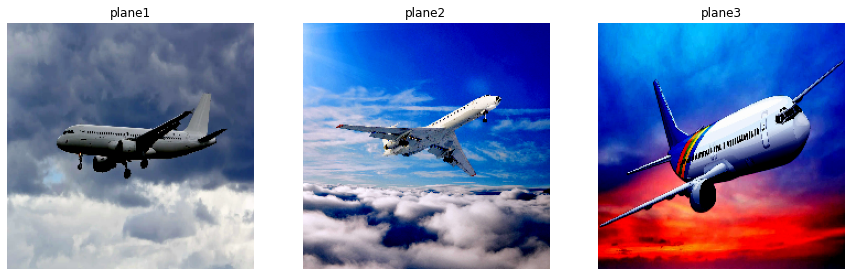

In [4]:
plane1 = load_preprocess('../images/plane1.jpg')
plane2 = load_preprocess('../images/plane2.jpg')
plane3 = load_preprocess('../images/plane3.jpg')
# combine planes into a train dataset
# load_preprocess returns the image and the batch number, and we only need the image, ie plane[0]
samples = np.array([plane1[0], plane2[0],plane3[0]])
sample_labels = np.array(['plane1','plane2', 'plane3'])
utils.show_images(samples, sample_labels) 

#### Image  Compression

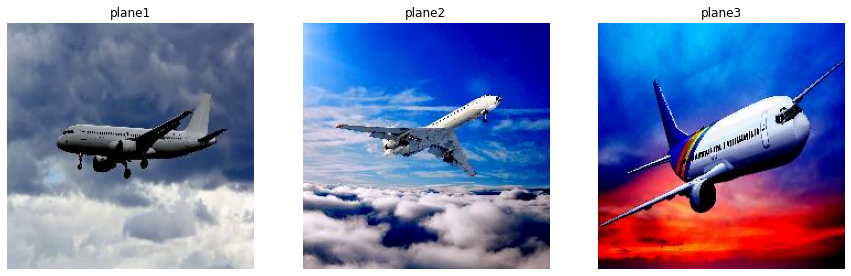

1/1 [==============================] - 1s 886ms/step


[[('n02690373', 'airliner', 0.94338834)],
 [('n04592741', 'wing', 0.6711445)],
 [('n02690373', 'airliner', 0.636532)]]

In [7]:
from art.defences.preprocessor import JpegCompression
# Apply JPEG Compression
jpeg_compression = JpegCompression(clip_values=(0, 1), quality=75, apply_predict=True)
samples_compressed = jpeg_compression(samples)[0]
utils.show_images(samples_compressed, sample_labels)
utils.predictions(samples_compressed)

#### Image  Rotation

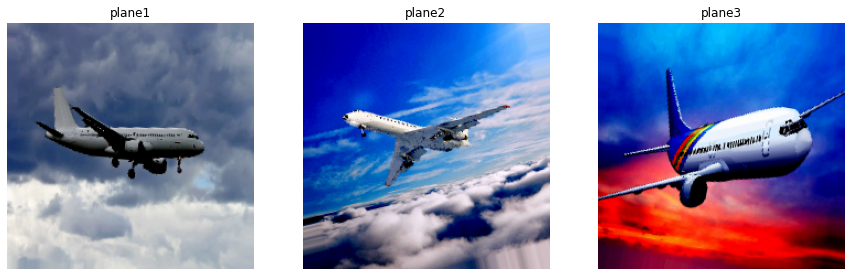

1/1 [==============================] - 0s 17ms/step


[[('n02690373', 'airliner', 0.86611813)],
 [('n04592741', 'wing', 0.70559615)],
 [('n02690373', 'airliner', 0.88744336)]]

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,  # Random rotations in the range (degrees, 0 to 180) 
    horizontal_flip=True,  # Randomly flip inputs horizontally 
    # ... include any other augmentations ...
)
samples_rotated = np.array([datagen.random_transform(img) for img in samples])
utils.show_images(samples_rotated, sample_labels)
utils.predictions(samples_rotated)

#### Feature Squeezing

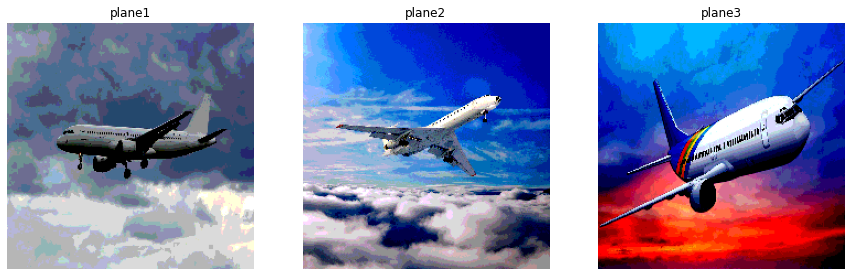

1/1 [==============================] - 0s 16ms/step


[[('n02690373', 'airliner', 0.8466958)],
 [('n04592741', 'wing', 0.59886473)],
 [('n02690373', 'airliner', 0.8589291)]]

In [20]:
from art.defences.preprocessor import FeatureSqueezing
# Initialize Feature Squeezing with bit depth reduction
bit_depth = 3  # Number of bits to keep in each color channel
feature_squeezing = FeatureSqueezing(clip_values=(0, 1), bit_depth=bit_depth)
# Apply Feature Squeezing to the dataset
samples_squeezed, _ = feature_squeezing(samples)
utils.show_images(samples_squeezed, sample_labels)
utils.predictions(samples_squeezed)


In [10]:
from art.attacks.evasion import FastGradientMethod
# Adversarial Training Example
# Generate adversarial training data
attack = FastGradientMethod(estimator=wrapper, eps=0.1)
samples_adv = attack.generate(x=samples)
utils.predictions(samples)

1/1 [==============================] - 0s 15ms/step


[[('n02690373', 'airliner', 0.94245857)],
 [('n04592741', 'wing', 0.850888)],
 [('n02690373', 'airliner', 0.84523404)]]

In [11]:
samples_adv = attack.generate(x=samples)
# Apply JPEG Compression
jpeg_compression = JpegCompression(clip_values=(0, 1), quality=75, apply_predict=True)
samples_adv_compressed = jpeg_compression(samples_adv)[0]
utils.predictions(samples_adv_compressed)

1/1 [==============================] - 0s 16ms/step


[[('n04266014', 'space_shuttle', 0.8988149)],
 [('n01698640', 'American_alligator', 0.6318368)],
 [('n02692877', 'airship', 0.9670811)]]

In [12]:
sample_adv__rotated = np.array([datagen.random_transform(img) for img in samples_adv])
utils.predictions(sample_adv__rotated)

1/1 [==============================] - 0s 16ms/step


[[('n04266014', 'space_shuttle', 0.94110405)],
 [('n01698640', 'American_alligator', 0.6773017)],
 [('n02692877', 'airship', 0.98710805)]]

In [22]:
samples_adv_squeezed, _ = feature_squeezing(samples_adv)
utils.predictions(sample_adv__rotated)

1/1 [==============================] - 0s 21ms/step


[[('n04266014', 'space_shuttle', 0.94110405)],
 [('n01698640', 'American_alligator', 0.6773017)],
 [('n02692877', 'airship', 0.98710805)]]